# STUDY 2: The accuracy of price ranges and how they differ across various price suppliers.


### Study assumption
Big prices are less accurate than
small prices.

### Data used
Betfair Exchange data from 2010 - 2022.

### Introduction

After determining which price suppliers
would offer the best returns (BSP), a natural next step was
to investigate the accuracy of BSP prices in more detail.
Specifically, I sought to compare the accuracy of starting
prices for lower-priced horses versus long shots. To do so,
it is important to first understand how starting prices are
calculated in the horse racing industry. 

#### Betfair Starting Prices (BSP)
As an exchange, BSP prices are based on
bets placed by both backers and layers in the market. One
of the benefits of the exchanges that we haven't covered
yet is that they offer you the ability to back (bet for
something to happen) as well as lay (bet against something happening). When laying
a horse in the exchange, you are risking:

Liability = (stake * price) - stake)

At the start of an event, the exchange looks at the relationship
between the amount of money requested at SP by opposing
customers and any unmatched Exchange bets to get a final
BSP price. 

#### Industry Starting Prices (ISP)
The bookmaker
starting price algorithm is not publicly known, but it is likely
that they use a similar process of weighing the trading volume
for different horses in a race (only backers as you can't lay with
a bookmaker) and incorporating their own stipulations for
capping their liability and long shot prices.

### Key Findings

- ROI remains steady at lower price ranges, but gradually increases as prices move from small to medium ranges. However, ROI decreases exponentially as prices exceed three figures
- While laying prices over 500 may offer a potentially high ROI, the practical challenges associated with this approach, such as increased liability and the need for a substantial bankroll, make it difficult to sustain long-term profitability. Moreover, the number of lay bets per race also impacts the ROI, which tends to increase at higher price ranges.

### EDA

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings

In [2]:
warnings.filterwarnings("ignore")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set(rc={'figure.figsize':(2.5,1.5)})
sns.set_style("white")

In [3]:
title_font = {'family': 'Trebuchet MS', 'weight': 'semibold', 'size': 5, 'color': 'dimgrey'}
label_font = {'family': 'Trebuchet MS', 'size': 4, 'color': 'dimgrey'}

In [4]:
cols=[ 'date', 'time', 'runners', 'name', 'bsp', 'bspr', 'W/L']
df = pd.read_csv('data/2010-22_BSP Data.csv', low_memory=False, usecols=cols)

In [5]:
df.head()

,name,W/L,bsp,date,time,runners,bspr
0,The Sneezer,0.0,4.134344,01/01/2010,12:20,8,-1.000000
1,Echo Bob,0.0,4.734877,01/01/2010,12:20,8,-1.000000
2,Club Oscar,0.0,5.910360,01/01/2010,12:20,8,-1.000000
3,Grand Lahou,1.0,7.472524,01/01/2010,12:20,8,6.343073
4,Nans Best,0.0,9.246182,01/01/2010,12:20,8,-1.000000


First, let's compare Profit/Loss when backing different price ranges by splitting all BSP prices into 10 different decile groups.

In [6]:
price_compare = (df
                 .loc[:, ['bsp', 'bspr']]
                 .query('bsp<=1000')
                 .assign(decile=lambda price_compare : pd.qcut(price_compare["bsp"],
                                                                   q=10, precision=0, labels=range(1, 11))))

In [7]:
(price_compare
 .loc[:, ['bsp', 'bspr', 'decile']]
 .groupby('decile')
 .agg({'bspr': 'sum', 'bsp': 'mean', 'decile': 'count'})
 .assign(roi=lambda price_compare: (((
     price_compare.decile + price_compare.bspr) / price_compare.decile) * 100)-100)
 .loc[:, ['bsp', 'roi', 'decile']]
 .rename(columns={'bsp': 'Average BSP', 'roi': 'ROI(%)', 'decile': 'Number of Prices'}))

,Average BSP,ROI(%),Number of Prices
decile,,,
1,2.934837,-2.135374,153336
2,5.013405,-2.190577,153336
3,7.072399,-2.458527,156661
4,9.467387,-3.171291,150010
5,12.672198,-0.870081,153336
6,17.325810,0.831420,153335
7,24.658753,-0.417450,153336
8,37.926488,-1.031373,153335
9,76.531271,-5.511036,153336


`barplot` showing the total profit/loss of the 10 deciles from 2010-22.

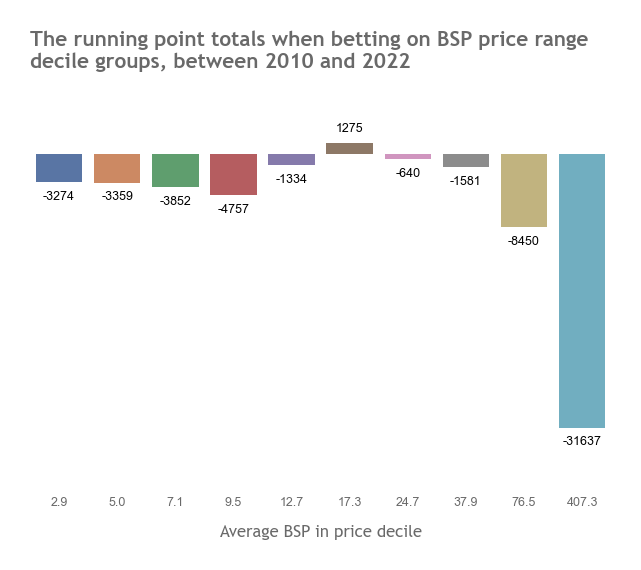

In [8]:
# create the figure and axes
fig, ax = plt.subplots()

# plot barplot
sns.barplot(x='decile', y='bspr' , data=price_compare, errorbar=None, estimator=sum, edgecolor='.3', linewidth=0, ax=ax)

# set title and axis labels
ax.set_title('The running point totals when betting on BSP price range\ndecile groups, between 2010 and 2022',
             fontdict=title_font, x=0, y=1.05, ha='left')
ax.set_ylabel('')
ax.set_xlabel('Average BSP in price decile', fontdict=label_font)
avg_bsp = (price_compare.groupby('decile')['bsp'].mean().astype('float').round(1))
ax.set_xticklabels(avg_bsp)

# adjust axis, grid lines
sns.despine(left=True, bottom=True)

# adjust parameters
ax.tick_params(colors='dimgrey', labelsize=3)
plt.yticks([], [])

#set range
plt.ylim(-35000,5000)

# add bar labels
bar_labels = ['{:.0f}'.format(rect.get_height())for rect in ax.containers[0]]
plt.bar_label(ax.containers[0], fontsize=3, color='black', weight='normal', padding=2, labels=bar_labels)

plt.show()

Now we split the 10 deciles into 3 larger groups, representing `small`, `medium` and `big` prices.

In [9]:
small_prices = price_compare[price_compare.decile<4]
medium_prices = price_compare[(price_compare.decile>=4) & (price_compare.decile<=7)]
big_prices = price_compare[price_compare.decile>7]

In [10]:
print(f'Small Prices ROI = {((((small_prices.bspr.sum()+len(small_prices)))-len(small_prices)) / len(small_prices) * 100).round(2)}%')
print(f'Medium Prices ROI = {((((medium_prices.bspr.sum()+len(medium_prices)))-len(medium_prices)) / len(medium_prices) * 100).round(2)}%')
print(f'Big Prices ROI = {((((big_prices.bspr.sum()+len(big_prices)))-len(big_prices)) / len(big_prices) * 100).round(2)}%')

Small Prices ROI = -2.26%
Medium Prices ROI = -0.89%
Big Prices ROI = -9.06%


In [11]:
price_compare['decile'].corr(price_compare['bspr'])

-0.004574802322766886

As we noted in Study 1, the occurrence of the maximum price of 1000 was quite frequent. To delve deeper, we can compare the distribution of prices across different price ranges using a histogram.

`histplot` showing the frequency of Betfair Starting Prices (BSP).

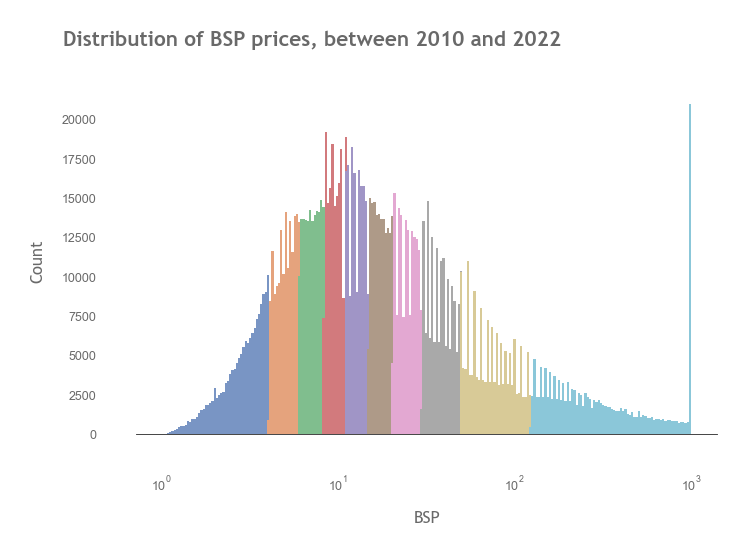

In [12]:
# create the figure and axes
fig, ax = plt.subplots()

# plot histplot
sns.histplot(price_compare, x="bsp", hue="decile", multiple="stack", 
             edgecolor=".3", log_scale=True, legend=False, linewidth=0, ax=ax)

# set title and axis labels
ax.set_title('Distribution of BSP prices, between 2010 and 2022', fontdict=title_font, x=-0.125, y=1.05, ha='left')
ax.set_ylabel('Count', fontdict=label_font)
ax.set_xlabel('BSP', fontdict=label_font)

# adjust axis, grid lines
sns.despine(left=True)
ax.spines['bottom'].set_linewidth(.2)

# adjust parameters
ax.tick_params(colors='dimgrey', labelsize=3)

plt.show()

To investigate whether BSP prices of 1000 are skewing the results, we can remove them and see if the same trend appears. 

`barplot` removing max prices of 1000.

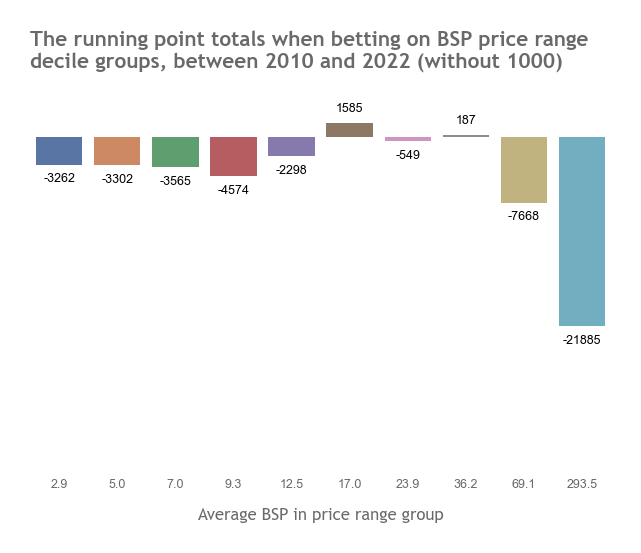

In [13]:
# data
price_compare_no_max = (df
                        .loc[:, ['bsp', 'bspr']]
                        .query('bsp<1000')
                        .assign(decile=lambda price_compare_no_max : pd.qcut(price_compare_no_max["bsp"],
                                                                   q=10, precision=0, labels=range(1, 11))))

# create the figure and axes
fig, ax = plt.subplots() 

# plot barplot
sns.barplot(x='decile', y='bspr' , data=price_compare_no_max, 
            errorbar=None, estimator=sum, edgecolor='.3', linewidth=0, ax=ax)


# set title and axis labels
ax.set_title('The running point totals when betting on BSP price range\ndecile groups, between 2010 and 2022 (without 1000)', fontdict=title_font, x=0, y=1,ha='left')
ax.set_ylabel('')
ax.set_xlabel('Average BSP in price range group', fontdict=label_font)
avg_bsp = (price_compare_no_max.groupby('decile')['bsp'].mean().astype('float').round(1))
ax.set_xticklabels(avg_bsp)

# adjust axis, grid lines
sns.despine(left=True, bottom=True)

# adjust parameters
ax.tick_params(colors='dimgrey', labelsize=3)
plt.yticks([], [])

# set range
plt.ylim(-35000,5000)

# add bar labels
bar_labels = ['{:.0f}'.format(rect.get_height())for rect in ax.containers[0]]
plt.bar_label(ax.containers[0], fontsize=3, color='black', weight='normal', padding=2, labels=bar_labels)


plt.show()

In [14]:
small_prices = price_compare_no_max[price_compare_no_max.decile<4]
medium_prices = price_compare_no_max[(price_compare_no_max.decile>=4) & (price_compare_no_max.decile<=7)]
big_prices = price_compare_no_max[price_compare_no_max.decile>7]

In [15]:
print(f'Small Prices ROI = {(((small_prices.bspr.sum()+len(small_prices))-len(small_prices)) / len(small_prices) * 100).round(2)}%')
print(f'Medium Prices ROI = {(((medium_prices.bspr.sum()+len(medium_prices))-len(medium_prices)) / len(medium_prices) * 100).round(2)}%')
print(f'Big Prices ROI = {(((big_prices.bspr.sum()+len(big_prices))-len(big_prices)) / len(big_prices) * 100).round(2)}%')

Small Prices ROI = -2.23%
Medium Prices ROI = -0.96%
Big Prices ROI = -6.47%


In [16]:
price_compare_no_max['decile'].corr(price_compare_no_max['bspr'])

-0.0030337031018756876

Despite observing a slight difference in return on investment, the general trend remains unchanged, with a significant decrease in ROI in the last two percentile groups, with average prices of 69 and 293, respectively.

Now that we have established that bigger prices are less favourable to bet on, how can we leverage this knowledge to our advantage? A
significant advantage of betting exchanges is the ability to both back and lay bets on a horse at the same BSP price. This means that
when you place a lay bet, your liability is the profit of the equivalent back bet. For instance, if you place a back bet on a BSP price of 10
at £1, your liability is -£1 if the bet loses, and your potential profit is +£9 if the bet wins. However, if you place a £1 lay bet on the same
price (i.e., betting against the horse winning), your liability becomes £-9 if the bet loses, and your potential profit is +£1 if it wins. Note
that this example does not consider the 2% commission on winning bets that can affect your winnings.


To capitalize on our findings that betting on horses with prices over 500 is the least profitable strategy, we can use this information to
our advantage by laying (betting against) these horses.

First, we need to create column showing the results of laying the horse at BSP price.

In [17]:
df['bsp_layr'] = 0.98
df.loc[df['W/L'] == 1, 'bsp_layr'] = -(1 * (df.bsp - 1))

`lineplot` showing the running point profit/loss when laying prices over 500 between 2010 and 2022.

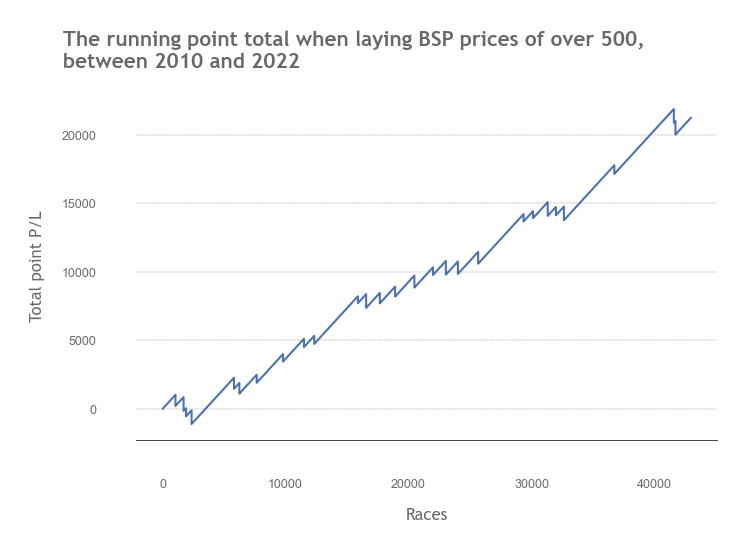

In [18]:
# data
laying_long_shots = (df
                     .query('bsp>500')
                     .reset_index(drop=True)
                     .loc[:, ['bsp_layr', 'bsp']])

# create the figure and axes
fig, ax = plt.subplots() 

# plot lineplot
data = laying_long_shots.loc[:, ['bsp_layr']].cumsum()
sns.lineplot(data=data, linewidth=.5, legend=False, color='steelblue', ax=ax)

# set title and axis labels
ax.set_title('The running point total when laying BSP prices of over 500,\nbetween 2010 and 2022', fontdict=title_font, x=-0.125, y=1,ha='left')
ax.set_ylabel('Total point P/L', fontdict=label_font)
ax.set_xlabel('Races', fontdict=label_font)

# adjust axis, grid lines
sns.despine(left=True)
ax.spines['bottom'].set_linewidth(.2)
ax.grid(True, axis='y', linestyle='--', linewidth=.1, color='grey')

# adjust parameters
ax.tick_params(colors='dimgrey', labelsize=3)

plt.show()

In [19]:
print(f'Number of bets = {(len(laying_long_shots))}')
print(f'Total Point Profit/Loss = {laying_long_shots.bsp_layr.sum().round(2)}')
print(f'ROI = {(((len(laying_long_shots) + laying_long_shots.bsp_layr.sum())-len(laying_long_shots)) / len(laying_long_shots) * 100).round(2)}%')
print(f'Total Winning Bets = {len(laying_long_shots.loc[laying_long_shots.bsp_layr>0])}')
print(f'Total Loosing Bets = {len(laying_long_shots.loc[laying_long_shots.bsp_layr<0])}')
print(f'Average BSP = {laying_long_shots.bsp.mean().round()}')

Number of bets = 42957
Total Point Profit/Loss = 21255.62
ROI = 49.48%
Total Winning Bets = 42930
Total Loosing Bets = 27
Average BSP = 843.0


 As expected, this strategy yields very promising results, with a return on investment of nearly 50% and over 40,000
winning bets compared to only 27 losing bets, all at an average price of 843 over a 12-year period. To examine the practicality of this
laying strategy, we need to assess the percentage of races with at least one horse priced over 500 that we would be trading in.
Additionally, it is important to determine the average number of horses we would need to lay in those races.

In [20]:
races = len(df.query('bsp>500').groupby(['date', 'time'],as_index=False))/len(df.groupby(['date', 'time']))

In [21]:
trades = (len(laying_long_shots)) / len(df.query('bsp > 500').groupby(['date', 'time'],as_index=False))

In [22]:
print(f'Percentage of Races active in = {(races)*100}%')

Percentage of Races active in = 14.037286641053095%


In [23]:
print(f'Average trades per race with at least one trade = {trades}')

Average trades per race with at least one trade = 1.9274464934715305


Now let's see the average bankroll required to implement our laying strategy for different stake levels based on a mean BSP price of 843.

In [24]:
data={'stake(£)': [1,5,10,25,50,100], 'ave_price_laying': laying_long_shots.bsp.mean().round(), 'ave_trades': trades}

In [25]:
liability = (pd.DataFrame(data=data)
             .assign(average_race_liability=lambda x: ((x['stake(£)']*(x['ave_price_laying']- x['stake(£)'])) * x['ave_trades']).astype('int'))
             .rename(columns={'average_race_liability': 'average_race_liability(£)'}))

In [26]:
liability[['stake(£)', 'average_race_liability(£)']]

,stake(£),average_race_liability(£)
0,1,1622
1,5,8076
2,10,16055
3,25,39416
4,50,76423
5,100,143209


The results above indicate that although we are only active in 14 out of every 100 races, due to the extremely high prices we are working with, laying just a stake of £1 on (mean of 1.9) horses in a race would require an average bankroll of £1622.

To optimize our bankroll usage, we need to limit the number of horses we lay per race. Let's look at the distribution of races with different numbers of horses with prices over 500 (Lay Trades).

`histplot` that shows the frequency of the number of horses we need to lay in races that have at least one.

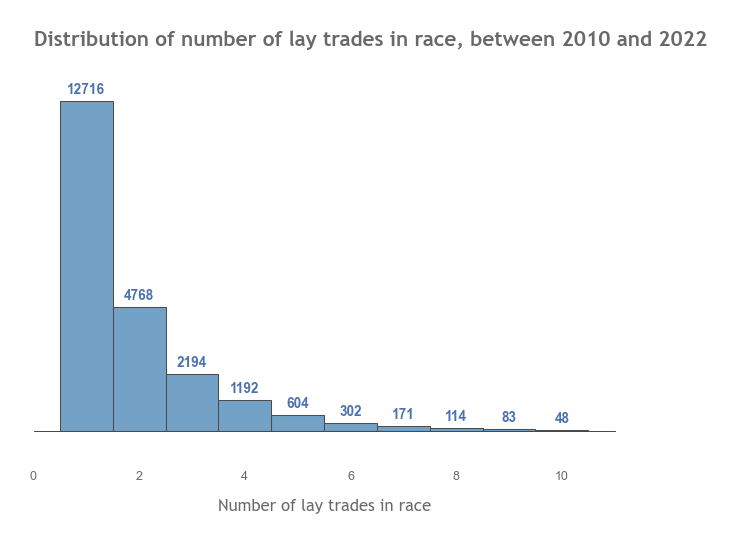

In [27]:
# data
races_long_shots = (df
                    .query('bsp > 500')
                    .groupby(['date', 'time'],as_index=False)
                    .agg({'name': 'count', 'bsp_layr': 'sum', 'runners': 'first'})
                    .rename(columns=({'name': 'amount_of_lay_runners'}))
                   )
# create the figure and axes
fig, ax = plt.subplots() 

# plot histplot
sns.histplot(data=races_long_shots.query('amount_of_lay_runners<=10'), x='amount_of_lay_runners',
             edgecolor=".3",  discrete=True, legend=False, linewidth=.25, color='steelblue', ax=ax)

# adjust params and set title, labels
# set title and axis labels
ax.set_title('Distribution of number of lay trades in race, between 2010 and 2022', fontdict=title_font, x=0, y=1.04,ha='left')
ax.set_ylabel('')
ax.set_xlabel('Number of lay trades in race', fontdict=label_font)

# adjust axis, grid lines
sns.despine(left=True)
ax.spines['bottom'].set_linewidth(.2)

# adjust parameters
ax.tick_params(colors='dimgrey', labelsize=3)
plt.yticks([], [])

# add bar labels
bar_labels = ['{:.0f}'.format(rect.get_height())for rect in ax.containers[0]]
plt.bar_label(ax.containers[0], fontsize=3.25, color='b', weight='semibold', padding=1, labels=bar_labels)

plt.show()

We see that the vast majority of races have 1 horse with prices of 500+. However, before concluding that we should limit the number of horses we lay per race, we need to investigate if there is a difference in return on investment between races with differing numbers of horses with prices of 500+. We can do this by grouping races by the number of horses with prices over 500 and calculating the average ROI for each group.

`barplot` that reveals the total return on investment for races with different numbers of horses with prices over 500.

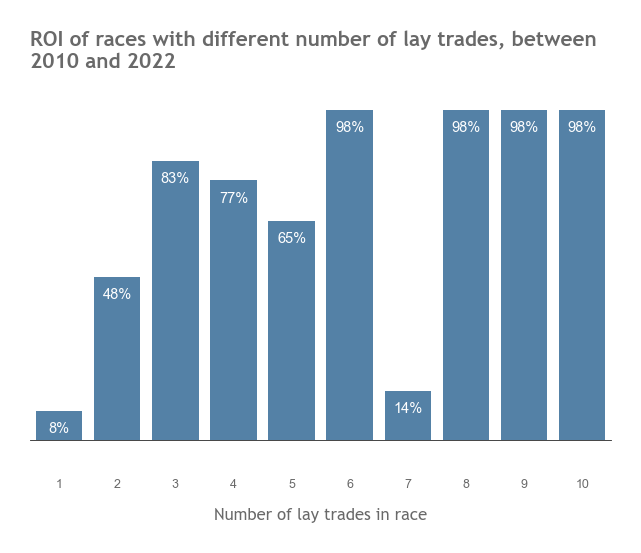

In [28]:
# data
data_ = (races_long_shots
        .groupby('amount_of_lay_runners')
        .agg({'amount_of_lay_runners': 'sum', 'bsp_layr': 'sum', 'runners': 'mean'})
        .assign(ROI=lambda races_long_shots: ((((
            races_long_shots.amount_of_lay_runners + races_long_shots.bsp_layr))-races_long_shots.amount_of_lay_runners) / 
            races_long_shots.amount_of_lay_runners).round(3) * 100)
        .iloc[:10])

# create the figure and axes
fig, ax = plt.subplots() 

# plot barplot
sns.barplot(data=data_, x=data_.index, y='ROI', edgecolor='.3', color='steelblue', linewidth=0, ax=ax)

# set title and axis labels
ax.set_title('ROI of races with different number of lay trades, between\n2010 and 2022', fontdict=title_font, x=0, y=1,ha='left')
ax.set_xlabel('Number of lay trades in race', fontdict=label_font)
ax.set_ylabel('')

# adjust axis, grid lines
sns.despine(left=True)
ax.spines['bottom'].set_linewidth(.2)

# adjust parameters
ax.tick_params(colors='dimgrey', labelsize=3)
plt.yticks([], [])

# add bar labels
bar_labels = ['{:.0f}%'.format(rect.get_height())for rect in ax.containers[0]]
plt.bar_label(ax.containers[0], fontsize=3.5, color='white', weight='normal', padding=-6, labels=bar_labels)

# add '%' symbol to y-axis tick labels
tick_labels = [f'{int(label)}%' for label in ax.get_yticks()]
ax.set_yticklabels(tick_labels)

plt.show()

Seeing average and max liability per race betting (assuming only laying max of 5 horses in any one race).

In [29]:
liability['max_race_liability(£)'] = ((liability['stake(£)']*(liability['ave_price_laying']- liability['stake(£)'])) * 5).astype('int')
liability[['stake(£)', 'average_race_liability(£)', 'max_race_liability(£)']]

,stake(£),average_race_liability(£),max_race_liability(£)
0,1,1622,4210
1,5,8076,20950
2,10,16055,41650
3,25,39416,102250
4,50,76423,198250
5,100,143209,371500


These results reinforces the issue of liability, revealing that races featuring only one horse with a
price of 500 or more yield a considerably lower return on investment compared to those with a larger number of horses that need to be
layed. That being said, the reason for such a drastic disparity in ROI could be due to the negative correlation between number of lay trades in race and number of races active in. This will be explored further in another study.